# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden, "Reviewer" - 25 July 2020 - **Review required!**

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
TODO: Complete GitHub automation. Progress: can install all libaries with conda, but issue running this complex notebook remotely in a GitHub Action. Move to a flat python file next.

Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive_model_action.yaml` to run remotely.

In [2]:
us_run = False

In [3]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirements.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. Remote run is not required. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [4]:
if us_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [5]:
if us_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [6]:
if us_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

## Summarize Model Output

In [7]:
result = pd.DataFrame()
if us_run:
    result = summarize_inference_data(gm.inference_data)
result.tail(10)

""


## Plot Model Output

In [8]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if us_run:
    plot_results()

In [9]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if us_run:
    plot_rt()

# South African Results

## Download data

In [10]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-20,20200720,65316.0,10727.0,136879.0,45614.0,5156.0,7424.0,2351.0,14337.0,85772.0,52.0,373628,https://twitter.com/nicd_sa/status/12853467780...
2020-07-21,20200721,66759.0,11352.0,139435.0,47685.0,5355.0,7664.0,2539.0,14634.0,86329.0,46.0,381798,https://twitter.com/nicd_sa/status/12856772968...
2020-07-22,20200722,67818.0,12332.0,144582.0,50521.0,5712.0,8286.0,2727.0,15073.0,87847.0,50.0,394948,https://twitter.com/nicd_sa/status/12860532628...
2020-07-23,20200723,69445.0,13443.0,148854.0,53406.0,6068.0,8987.0,2970.0,15901.0,88928.0,50.0,408052,https://twitter.com/nicd_sa/status/12863909561...
2020-07-24,20200724,71338.0,14542.0,153020.0,57162.0,6394.0,9756.0,3175.0,16548.0,90011.0,50.0,421996,https://twitter.com/nicd_sa/status/12867360173...


In [11]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-07-20,20200720,2505646.0,194865,NaN,NaN,NaN,5173,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/20/update-...
2020-07-21,20200721,2536921.0,208144,NaN,NaN,NaN,5368,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/21/update-...
2020-07-22,20200722,2585474.0,229175,NaN,NaN,NaN,5940,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/22/update-...
2020-07-23,20200723,2632106.0,236260,NaN,NaN,NaN,6093,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/23/update-...
2020-07-24,20200724,2684488.0,245771,NaN,NaN,NaN,6343,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/24/update-...


## Cleanup data

In [12]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-20    373628
2020-07-21    381798
2020-07-22    394948
2020-07-23    408052
2020-07-24    421996
Name: cases, Length: 140, dtype: int64

In [13]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-24 00:00:00'))

In [14]:
idx = pd.date_range(casezero, caselast)

In [15]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-07-20    2505646.0
2020-07-21    2536921.0
2020-07-22    2585474.0
2020-07-23    2632106.0
2020-07-24    2684488.0
Name: tests, Length: 147, dtype: float64

In [16]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-07-20    2505646.0
2020-07-21    2536921.0
2020-07-22    2585474.0
2020-07-23    2632106.0
2020-07-24    2684488.0
Name: tests, Length: 138, dtype: float64

In [17]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-20,373628.0,2505646.0
2020-07-21,381798.0,2536921.0
2020-07-22,394948.0,2585474.0


In [18]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [19]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-20,373628.0,2505646.0
2020-07-21,381798.0,2536921.0
2020-07-22,394948.0,2585474.0
2020-07-23,408052.0,2632106.0


In [20]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-07-20,373628.0,2505646.0
2020-07-21,381798.0,2536921.0
2020-07-22,394948.0,2585474.0
2020-07-23,408052.0,2632106.0


In [21]:
# Add delta columns for models
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-07-20,373628.0,2505646.0,9300.0,33899.0
2020-07-21,381798.0,2536921.0,8170.0,31275.0
2020-07-22,394948.0,2585474.0,13150.0,48553.0
2020-07-23,408052.0,2632106.0,13104.0,46632.0


In [22]:
df_model = final_filled_model.iloc[1:]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-07-20,373628.0,2505646.0,9300.0,33899.0
2020-07-21,381798.0,2536921.0,8170.0,31275.0
2020-07-22,394948.0,2585474.0,13150.0,48553.0
2020-07-23,408052.0,2632106.0,13104.0,46632.0


## Calculate Rt

In [23]:
region = 'Total RSA'

In [24]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [10:22<00:00,  5.79draws/s]


## Show results

In [25]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 371.37it/s]


In [26]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-15,1.040711,1.038998,0.868361,1.182381,7923.804525,9122.460449,9562.911598,12757.0,45389.0
2020-07-16,1.043115,1.039022,0.886011,1.211036,8005.706705,9233.669781,9577.125750,13172.0,46796.0
2020-07-17,1.045315,1.038114,0.867712,1.199860,8090.297987,9340.460527,9453.773284,13373.0,48130.0
2020-07-18,1.045469,1.040723,0.874985,1.223189,8181.017065,9443.699962,9097.084790,13285.0,49688.0
2020-07-19,1.047320,1.041653,0.831329,1.195017,8280.657325,9544.452681,9337.549949,13449.0,49006.0
2020-07-20,1.049468,1.036283,0.836108,1.210221,8388.610402,9643.772386,9334.439854,9300.0,33899.0
2020-07-21,1.051888,1.042587,0.814638,1.197237,8504.954115,9742.633659,8888.263850,8170.0,31275.0
2020-07-22,1.052679,1.042468,0.839042,1.217688,8631.456104,9841.860663,9215.138855,13150.0,48553.0
2020-07-23,1.053645,1.041750,0.851021,1.260097,8770.118327,9942.124762,9561.192061,13104.0,46632.0


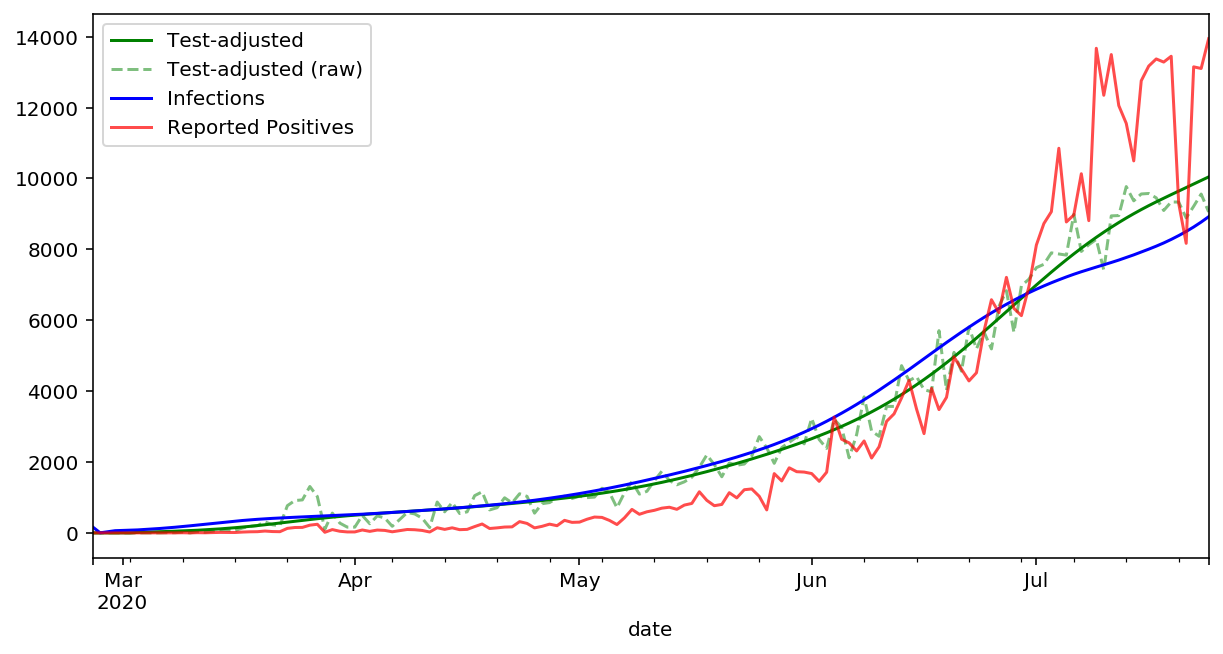

In [27]:
plot_results()

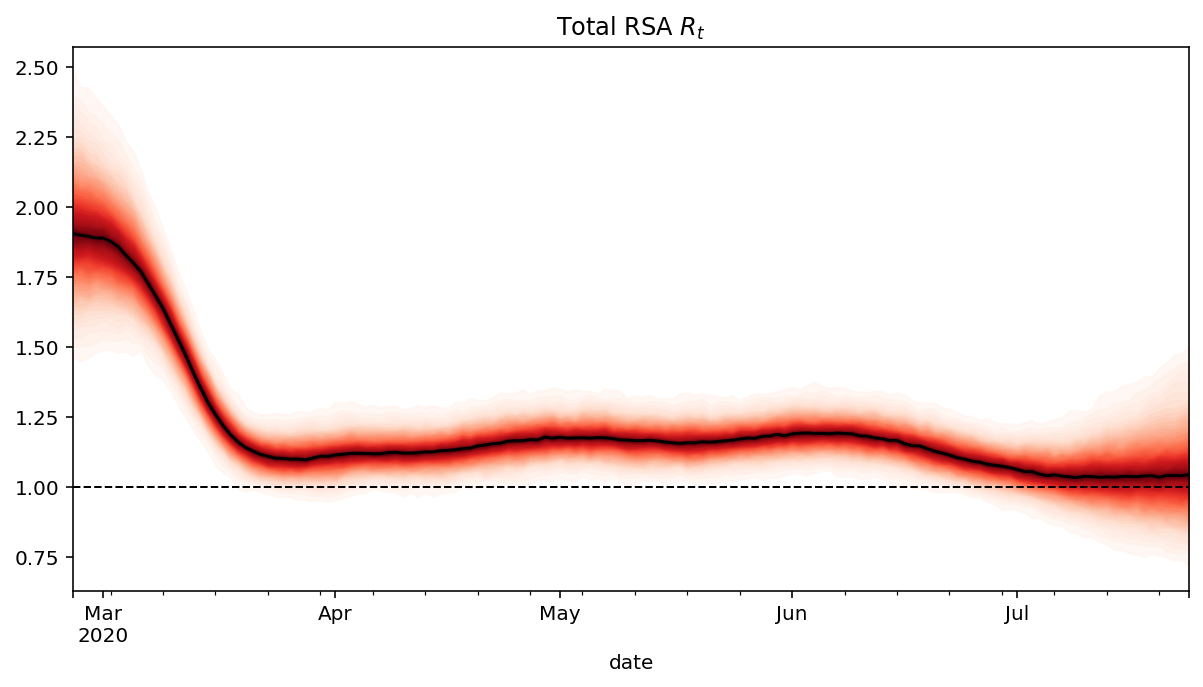

In [28]:
plot_rt()

In [29]:
export_results = result[['median','upper_80','lower_80','infections','test_adjusted_positive']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80','infections':'Infections','test_adjusted_positive':'Adjusted_Postive'})
export_results.tail()

,Median,High_80,Low_80,Infections,Adjusted_Postive
date,,,,,
2020-07-20,1.036283,1.210221,0.836108,8388.610402,9643.772386
2020-07-21,1.042587,1.197237,0.814638,8504.954115,9742.633659
2020-07-22,1.042468,1.217688,0.839042,8631.456104,9841.860663
2020-07-23,1.041750,1.260097,0.851021,8770.118327,9942.124762
2020-07-24,1.046056,1.252744,0.828636,8921.042186,10044.239302


## Export results

In [30]:
if remote_run:
    # Used by GitHub Action, TODO complete the action!
    # The path needs to be linked directly, TODO find out why relative path does not work
    # Action instance path /home/runner/work/covid19za/covid19za
    export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')

else:
    export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')